# Análisis de embudo de ventas y prueba A/B

En el presente proyecto se investigará el comportamiento del usuario de la aplicación de una empresa que vende productos alimenticios. Primero se estudiará el embudo de ventas de la aplicación para conocer cómo los usuarios(as) llegan a la etapa de compra. Posteriormente, se analizarán los resultados de un test A/A/B con la finalidad de ayudar a la toma de decisiones sobre la implementación de un cambio en las fuentes de toda la aplicación. 


## Importación de librerías y carga de datos

In [2]:
# importación de librerías a usar en el proyecto
import pandas as pd
import numpy as np
import math as mth
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
from plotly import graph_objects as go

In [3]:
import os

# Cambio al directorio donde está el archivo CSV
os.chdir(r'C:\Users\steph\Documents\Proyecto_embudo y prueba AB') 

print("Nuevo directorio de trabajo:", os.getcwd())


Nuevo directorio de trabajo: C:\Users\steph\Documents\Proyecto_embudo y prueba AB


In [4]:
#creación del dataframe
df = pd.read_csv('logs_exp_us.csv', sep='\t')
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


## Preprocesamiento de datos

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


No existen datos ausentes

In [6]:
# búsqueda de filas completamente duplicadas
print(df.duplicated().sum())

413


In [7]:
duplicados = df[df.duplicated(keep=False)]
print(duplicados)

                      EventName         DeviceIDHash  EventTimestamp  ExpId
452            MainScreenAppear  5613408041324010552      1564474784    248
453            MainScreenAppear  5613408041324010552      1564474784    248
2348           CartScreenAppear  1694940645335807244      1564609899    248
2350           CartScreenAppear  1694940645335807244      1564609899    248
3572           MainScreenAppear   434103746454591587      1564628377    248
...                         ...                  ...             ...    ...
242359  PaymentScreenSuccessful  2382591782303281935      1565206049    246
242360  PaymentScreenSuccessful  2382591782303281935      1565206049    246
242362         CartScreenAppear  2382591782303281935      1565206049    246
242634         MainScreenAppear  4097782667445790512      1565206618    246
242635         MainScreenAppear  4097782667445790512      1565206618    246

[768 rows x 4 columns]


In [8]:
# se eliminarán las filas duplicadas 
df = df.drop_duplicates(keep='first').reset_index(drop=True)
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       243713 non-null  object
 1   DeviceIDHash    243713 non-null  int64 
 2   EventTimestamp  243713 non-null  int64 
 3   ExpId           243713 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.4+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,1565212345,247
243709,MainScreenAppear,5849806612437486590,1565212439,246
243710,MainScreenAppear,5746969938801999050,1565212483,246
243711,MainScreenAppear,5746969938801999050,1565212498,246


In [9]:
# conversión del nombre de las columnas a formato snake_case
df.columns=['event_name','user_id','event_fulldate','exp_group']
df.head()

,event_name,user_id,event_fulldate,exp_group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [10]:
# conversión de columnas al tipo de datos correcto para cada una
df['user_id']=df['user_id'].astype(str)
df['event_fulldate']=df['event_fulldate'].apply(lambda x: pd.to_datetime(x, unit = 's'))
df['exp_group'] = df['exp_group'].astype(str)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_name      243713 non-null  object        
 1   user_id         243713 non-null  object        
 2   event_fulldate  243713 non-null  datetime64[ns]
 3   exp_group       243713 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 7.4+ MB


,event_name,user_id,event_fulldate,exp_group
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


In [11]:
# creación de columnas de fecha y hora
df['date'] = df['event_fulldate'].dt.date
df['hour'] = df['event_fulldate'].dt.hour
df.head()

,event_name,user_id,event_fulldate,exp_group,date,hour
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25,4
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25,11
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25,11


## Análisis general de los datos

### Exploración de registros

In [12]:
print(df['event_name'].nunique())
df['event_name'].unique()

5


array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

Existen 5 eventos diferentes en los registros. El orden en el que suceden parecer ser el siguiente:
1. MainScreenAppear
2. OffersScreenAppear
3. CartScreenAppear
4. PaymentScreenSuccesful

El evento denominado Tutorial no parece estar relacionado al embudo porque podría ser una paso opcional para los usuarios

In [13]:
df['user_id'].nunique()

7551

Existen 7551 usuarios(as) únicos(as)

### Promedio de eventos por usuario

In [14]:
events_by_user= df.groupby('user_id')['event_name'].nunique()
print(events_by_user)

user_id
1000608915523616548    2
100724994572555335     1
1008242126838007188    4
1009503747199967885    4
1009745980451513098    4
                      ..
992321565231279868     1
993193057518949787     1
995065401066914588     2
997141886226099626     1
997959739029313547     1
Name: event_name, Length: 7551, dtype: int64


In [15]:
print(events_by_user.mean())

2.6744802012978415


En promedio, cada usuario(a) pasa por alrededor de 3 eventos diferentes.

### Exploración de la distribución de datos a lo largo del tiempo (por fecha y hora)

In [16]:
print(df['date'].min())
print(df['date'].max())

2019-07-25
2019-08-07


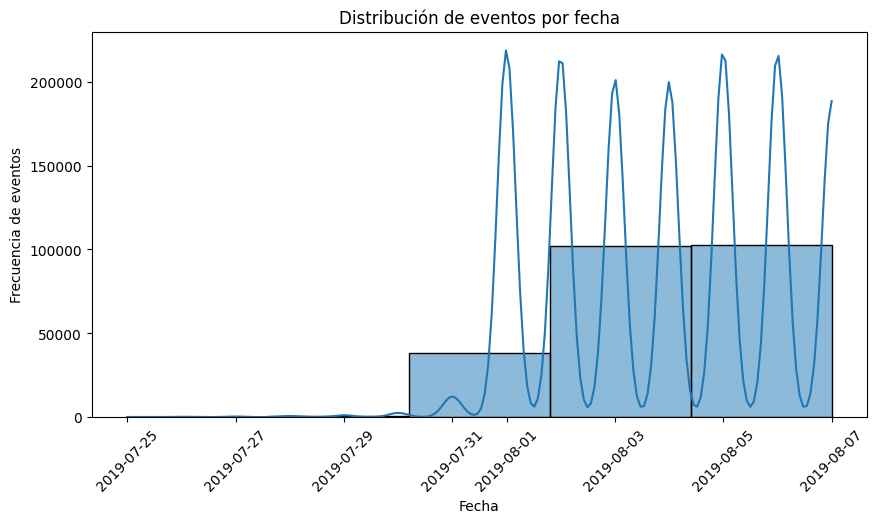

In [107]:
plt.figure(figsize=(10, 5))
sns.histplot(df['date'], bins=5, kde=True)
plt.xlabel('Fecha')
plt.ylabel('Frecuencia de eventos')
plt.title('Distribución de eventos por fecha')
plt.xticks(rotation=45)
plt.show()

Se puede ver que la frecuencia de eventos varía de manera notable, con una gran concentración de eventos en las fechas cercanas al 31 de julio y el 1 de agosto. Esto podría indicar que a partir de esos días se dieron eventos masivos o actividades con una alta cantidad de interacciones. 

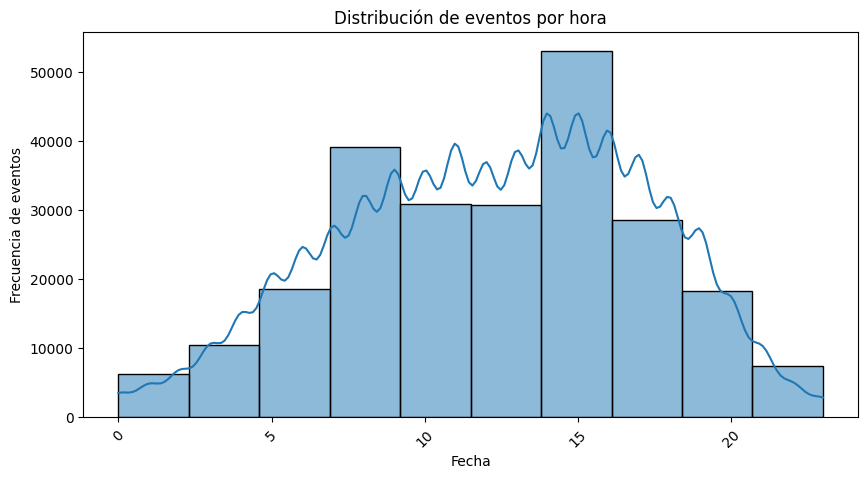

In [109]:
plt.figure(figsize=(10, 5))
sns.histplot(df['hour'], bins=10, kde=True)
plt.xlabel('Fecha')
plt.ylabel('Frecuencia de eventos')
plt.title('Distribución de eventos por hora')
plt.xticks(rotation=45)
plt.show()

En general, la distribución sugiere que la mayor parte de los eventos ocurren durante ciertas horas del día, con una disminución gradual a medida que avanza la noche. La densidad estimada (línea azul) muestra que los eventos tienden a ser más frecuentes entre las 9:00 y 16:00 horas. Asimismo, se muestra un notable pico alrededor de las 15:00 horas (3:00 PM), lo que sugiere que en ese momento se produce la mayor cantidad de eventos. También se observa una distribución más baja en las primeras horas de la mañana (por ejemplo, entre las 0:00 y 6:00 horas), lo que indica que los eventos son menos frecuentes durante ese periodo.

In [21]:
df['date']= pd.to_datetime(df['date'])

In [22]:
# se filtrarán los datos previos al 31 de julio de 2019
df_filtered =df[df['date']>pd.to_datetime('2019-07-31')]
print(f"""
Fecha mínima: {df_filtered['date'].min()}
Fecha máxima: {df_filtered['date'].max()}
""")


Fecha mínima: 2019-08-01 00:00:00
Fecha máxima: 2019-08-07 00:00:00



###  Se comprobará la integridad de los datos después de filtrar los registros anteriores al 1 de agosto 

In [23]:
df_filtered['user_id'].nunique()/df['user_id'].nunique()

0.9977486425638988

In [24]:
df_filtered['event_name'].count()/df['event_name'].count()

0.988404393692581

Al eliminar los datos antiguos se conservan el 99,7% de los(as) usuarios(as) originales y el 98,8% de los eventos originales 

### Se comprobará la cantidad de registros para los tres grupos experimentales.

In [25]:
df_filtered.groupby('exp_group')['user_id'].nunique()

exp_group
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

Se puede ver que tenemos un número de usuarios similar dentro de cada grupo experimental

## Análisis del embudo de eventos

### Frecuencia de suceso de eventos

In [ ]:
# frecuencia de suceso de eventos
df_filtered.groupby('event_name')['user_id'].count().sort_values(ascending=False)

event_name
MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: user_id, dtype: int64

In [27]:
# conteo de usuarios únicos que pasaron por cada evento
df_filtered.groupby("event_name")['user_id'].nunique().sort_values(ascending = False)

event_name
MainScreenAppear           7419
OffersScreenAppear         4593
CartScreenAppear           3734
PaymentScreenSuccessful    3539
Tutorial                    840
Name: user_id, dtype: int64

Se puede ver que los eventos ocurren en el siguiente orden: 
1. MainScreenAppear. 
2. OffersScreenAppear
3. CartScreenAppear
4. PaymentScreenSuccesful

Sin embargo, el evento Tutorial no parece pertenecer a la secuencia de eventos, ya que no es tan frecuente como los demás, por lo que se puede asumir que es un paso opcional al interactuar con la página. Por ello, dicho paso se excluirá al momento de crear el embudo.

### Creación de embudo para análisis de las tasas de conversión y cancelación

In [28]:
funnel = df_filtered.groupby("event_name")['user_id'].nunique().sort_values(ascending = False).reset_index()
funnel['users_in_prev_step'] = funnel['user_id'].shift(1)
funnel['conversion_rate'] = funnel['user_id']/funnel['users_in_prev_step']
funnel['cancelation_rate'] = 1 - funnel['conversion_rate'] 
funnel

,event_name,user_id,users_in_prev_step,conversion_rate,cancelation_rate
0,MainScreenAppear,7419,NaN,NaN,NaN
1,OffersScreenAppear,4593,7419.0,0.619086,0.380914
2,CartScreenAppear,3734,4593.0,0.812976,0.187024
3,PaymentScreenSuccessful,3539,3734.0,0.947777,0.052223
4,Tutorial,840,3539.0,0.237355,0.762645


In [29]:
fig = go.Figure(go.Funnel(
     y = ['MainScreenAppear','OffersScreenAppear','CartScreenAppear', 'PaymentScreenSuccessful'],
     x = [7419,4593,3734,3539],
     textinfo = "value+percent initial")
    )
fig.show()

De acuerdo al gráfico, parece ser que la etapa en la que se pierden a más usuarios(as) es el momento en el que se les muestra las ofertas, ya que el 61% de los usuarios iniciales que vieron la página principal llegan a dicha etapa. Para el resto de etapas la tasa de conversión se ubica entre 81% y 95%. 

Como se puede ver en el embudo, solo el 18,4% de los usuarios(as) pasa por todos los eventos hasta realizar el pago.

## Análisis del test A/A/B

### ¿Cuántos usuarios y usuarias hay en cada grupo?

In [101]:
# cantidad de usuarios(as) en cada grupo
df_filtered.groupby('exp_group')['user_id'].nunique()


exp_group
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

In [31]:
# se crean variables con el número de usuarios(as) en cada grupo para el análisis posterior 
group_246 = 2484
group_247 = 2513
group_248 = 2537

Los tamaños de los grupos son parejos

### Comprobación de diferencias estadísticamente significativas entre eventos de compra de los grupos de control

#### Evento MainScreenAppear

Primero se comprobará la diferencia de proporciones en la conversión del evento MainScreenAppear por ser el evento más popular

- H0: Las proporciones de conversión de los grupos 246 y 247 en el evento MainScreenAppear son iguales 
- H1: Las proporciones de conversión de los grupos 246 y 247 en el evento MainScreenAppear son diferentes

In [32]:
# se genera un dataframe base al que se le añadirá información sobre la conversión de cada usuario para cada evento
conversion = df_filtered[['user_id','exp_group']].drop_duplicates()
conversion

,user_id,exp_group
2826,3737462046622621720,246
2830,1433840883824088890,247
2831,4899590676214355127,247
2838,1182179323890311443,246
2842,4613461174774205834,248
...,...,...
242926,5811573131275421338,248
243129,5365227480683749189,248
243364,6660805781687343085,246
243407,7823752606740475984,246


In [33]:
main_screen_converted = pd.DataFrame(data= {
    "user_id": df_filtered[df_filtered['event_name'] == 'MainScreenAppear']['user_id'].unique(),
    "converted": 1
})

In [34]:
df_main_screen_converted = conversion.merge(main_screen_converted, on='user_id',how='left')
df_main_screen_converted['converted'] = df_main_screen_converted['converted'].fillna(0)
df_main_screen_converted

,user_id,exp_group,converted
0,3737462046622621720,246,1.0
1,1433840883824088890,247,1.0
2,4899590676214355127,247,1.0
3,1182179323890311443,246,1.0
4,4613461174774205834,248,1.0
...,...,...,...
7529,5811573131275421338,248,1.0
7530,5365227480683749189,248,1.0
7531,6660805781687343085,246,1.0
7532,7823752606740475984,246,1.0


In [35]:
user_246_main_screen = df_main_screen_converted[df_main_screen_converted['exp_group'] == "246"]['converted'].sum()
user_247_main_screen = df_main_screen_converted[df_main_screen_converted['exp_group'] == "247"]['converted'].sum()

In [36]:
user_246_main_screen

2450.0

In [37]:
# proporción de éxito en el grupo 246
p1 = user_246_main_screen/group_246
p1

0.9863123993558777

In [38]:
# proporción de éxito en el grupo 247
p2 = user_247_main_screen/group_247

In [39]:
#proporción de éxito combinado
p_combined = (user_246_main_screen+user_247_main_screen)/(group_246+group_247)
p_combined

0.9857914748849309

In [40]:
difference = p1-p2
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/group_246 + 1/group_247))

In [41]:
difference

0.0010358374776444634

In [42]:
alpha = .05 
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/group_246 + 1/group_247))
distr = st.norm(0, 1)
p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-value: ', p_value)

if (p_value < alpha):
    print("Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones")
else:
    print("No se pudo rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones")

p-value:  0.7570597232046099
No se pudo rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones


####  Evento OffersScreenAppear

- H0: Las proporciones de conversión de los grupos 246 y 247 son iguales 
- H1: Las proporciones de conversión de los grupos 246 y 247 son diferentes

In [43]:

offers_screen_converted = pd.DataFrame(data= {
    "user_id": df_filtered[df_filtered['event_name'] == 'OffersScreenAppear']['user_id'].unique(),
    "converted": 1
})

In [44]:
df_offers_screen_converted = conversion.merge(offers_screen_converted, on='user_id',how='left')
df_offers_screen_converted['converted'] = df_offers_screen_converted['converted'].fillna(0)
df_offers_screen_converted

,user_id,exp_group,converted
0,3737462046622621720,246,1.0
1,1433840883824088890,247,0.0
2,4899590676214355127,247,1.0
3,1182179323890311443,246,0.0
4,4613461174774205834,248,1.0
...,...,...,...
7529,5811573131275421338,248,0.0
7530,5365227480683749189,248,0.0
7531,6660805781687343085,246,0.0
7532,7823752606740475984,246,1.0


In [45]:
user_246_offers = df_offers_screen_converted[df_offers_screen_converted['exp_group'] == "246"]['converted'].sum()
user_247_offers = df_offers_screen_converted[df_offers_screen_converted['exp_group'] == "247"]['converted'].sum()

In [46]:
print(user_246_offers)

1542.0


In [47]:
print(user_247_offers)

1520.0


In [48]:
# proporción de éxito en el grupo 246
p1 = user_246_offers/group_246
p1

0.6207729468599034

In [49]:
# proporción de éxito en el grupo 247
p2 = user_247_offers/group_246
p2

0.6119162640901772

In [50]:
p_combined = (user_246_offers+user_247_offers)/(group_246+group_247)
difference = p1-p2

In [51]:
alpha = .05 
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/group_246 + 1/group_247))
distr = st.norm(0, 1)
p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-value: ', p_value)

if (p_value < alpha):
    print("Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones")
else:
    print("No se pudo rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones")

p-value:  0.520470233264319
No se pudo rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones


#### Evento CartScreenAppear

- H0: Las proporciones de conversión de los grupos 246 y 247 en el evento CartScreenAppear son iguales 
- H1: Las proporciones de conversión de los grupos 246 y 247 en el evento CartScreenAppear son diferentes

In [52]:
cart_screen_converted = pd.DataFrame(data= {
    "user_id": df_filtered[df_filtered['event_name'] == 'CartScreenAppear']['user_id'].unique(),
    "converted": 1
})

In [53]:
df_cart_screen_converted = conversion.merge(cart_screen_converted, on='user_id',how='left')
df_cart_screen_converted['converted'] = df_cart_screen_converted['converted'].fillna(0)
df_cart_screen_converted

,user_id,exp_group,converted
0,3737462046622621720,246,1.0
1,1433840883824088890,247,0.0
2,4899590676214355127,247,1.0
3,1182179323890311443,246,0.0
4,4613461174774205834,248,1.0
...,...,...,...
7529,5811573131275421338,248,0.0
7530,5365227480683749189,248,0.0
7531,6660805781687343085,246,0.0
7532,7823752606740475984,246,1.0


In [54]:
user_246_cart = df_cart_screen_converted[df_cart_screen_converted['exp_group'] == "246"]['converted'].sum()
user_247_cart = df_cart_screen_converted[df_cart_screen_converted['exp_group'] == "247"]['converted'].sum()
print(user_246_cart)
print(user_247_cart)

1266.0
1238.0


In [55]:
# proporción de éxito en el grupo 246
p1 = user_246_cart/group_246

# proporción de éxito en el grupo 247
p2 = user_247_cart/group_246


In [56]:
p_combined = (user_246_cart+user_247_cart)/(group_246+group_247)
difference = p1-p2

In [57]:
alpha = .05 
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/group_246 + 1/group_247))
distr = st.norm(0, 1)
p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-value: ', p_value)

if (p_value < alpha):
    print("Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones")
else:
    print("No se pudo rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones")

p-value:  0.4255613041874384
No se pudo rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones


#### Evento PaymentScreenSuccessful

- H0: Las proporciones de conversión de los grupos 246 y 247 en el evento PaymentScreenSuccessful son iguales 
- H1: Las proporciones de conversión de los grupos 246 y 247 en el evento PaymentScreenSuccessful son diferentes

In [58]:
payment_success_converted = pd.DataFrame(data= {
    "user_id": df_filtered[df_filtered['event_name'] == 'PaymentScreenSuccessful']['user_id'].unique(),
    "converted": 1
})

In [59]:
df_payment_success_converted = conversion.merge(payment_success_converted, on='user_id',how='left')
df_payment_success_converted['converted'] = df_payment_success_converted['converted'].fillna(0)
df_payment_success_converted.head()

,user_id,exp_group,converted
0,3737462046622621720,246,1.0
1,1433840883824088890,247,0.0
2,4899590676214355127,247,1.0
3,1182179323890311443,246,0.0
4,4613461174774205834,248,1.0


In [60]:
user_246_payment = df_payment_success_converted[df_payment_success_converted['exp_group'] == "246"]['converted'].sum()
user_247_payment = df_payment_success_converted[df_payment_success_converted['exp_group'] == "247"]['converted'].sum()
print(user_246_cart)
print(user_247_cart)

1266.0
1238.0


In [61]:
# proporción de éxito en el grupo 246
p1 = user_246_payment/group_246

# proporción de éxito en el grupo 247
p2 = user_247_payment/group_246

p_combined = (user_246_payment+user_247_payment)/(group_246+group_247)
difference = p1-p2

In [62]:
alpha = .05 
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/group_246 + 1/group_247))
distr = st.norm(0, 1)
p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-value: ', p_value)

if (p_value < alpha):
    print("Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones")
else:
    print("No se pudo rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones")

p-value:  0.2312650153600977
No se pudo rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones


Se puede concluir que los grupos de control se dividieron correctamente, pues en ninguno de los Z Test se revelaron diferencias estadísticamente significativas entre las proporciones de la conversión de ninguno de los eventos del embudo.

### Comprobación de diferencias estadísticamente significativas entre los grupos de control y el grupo de prueba para cada evento de forma aislada.

#### Grupo 248 vs Grupo 246

**Prueba 1 - evento MainScreenAppear** 

- H0: Las proporciones de conversión de los grupos 246 y 248 en el evento MainScreenAppear son iguales 
- H1: Las proporciones de conversión de los grupos 246 y 248 en el evento MainScreenAppear son diferentes

In [63]:
# cantidad de usuarios del grupo de prueba que pasaron por el evento MainScreenAppear
user_248_main_screen = df_main_screen_converted[df_main_screen_converted['exp_group'] == "248"]['converted'].sum()
user_248_main_screen

2493.0

In [64]:
group_248

2537

In [65]:
# se define una fórmula para realizar la prueba Z de manera más automática
def prueba_z(eventos1, n1, eventos2, n2, alpha=0.1):
    p1 = eventos1 / n1
    p2 = eventos2 / n2
    p_combined = (eventos1 + eventos2) / (n1 + n2)
    difference = p1-p2
    z_value = difference/mth.sqrt(p_combined * (1 - p_combined) * (1/n1 + 1/n2))
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    reject_null = p_value < alpha
    return p_value, reject_null
    


In [66]:
p, rechazar = prueba_z(user_248_main_screen, group_248, user_246_main_screen , group_246, alpha=0.1)
print(f"P-value: {p}")
if rechazar:
    print("Rechazamos la hipótesis nula: hay una diferencia significativa entre las proporciones")
else:
    print("No se puede rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones")

P-value: 0.2949721933554552
No se puede rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones


**Prueba 2 - evento OffersScreenAppear**

- H0: Las proporciones de conversión de los grupos 246 y 248 en el evento OffersScreenAppear son iguales 
- H1: Las proporciones de conversión de los grupos 246 y 248 en el evento OffersScreenAppear son diferentes

In [67]:
# cantidad de usuarios del grupo de prueba que pasaron por el evento MainScreenAppear
user_248_offers= df_offers_screen_converted[df_offers_screen_converted['exp_group'] == "248"]['converted'].sum()
user_248_offers

1531.0

In [68]:
p, rechazar = prueba_z(user_248_offers, group_248, user_246_offers , group_246, alpha=0.1)
print(f"P-value: {p}")
if rechazar:
    print("Rechazamos la hipótesis nula: hay una diferencia significativa entre las proporciones")
else:
    print("No se puede rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones")

P-value: 0.20836205402738917
No se puede rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones


**Prueba 3 - evento CartScreenAppear**

- H0: Las proporciones de conversión de los grupos 246 y 248 en el evento CartScreenAppear son iguales 
- H1: Las proporciones de conversión de los grupos 246 y 248 en el evento CartScreenAppear son diferentes

In [69]:
# cantidad de usuarios del grupo de prueba que pasaron por el evento MainScreenAppear
user_248_cart= df_cart_screen_converted[df_cart_screen_converted['exp_group'] == "248"]['converted'].sum()
user_248_cart

1230.0

In [70]:
p, rechazar = prueba_z(user_248_cart, group_248, user_246_cart , group_246, alpha=0.1)
print(f"P-value: {p}")
if rechazar:
    print("Rechazamos la hipótesis nula: hay una diferencia significativa entre las proporciones")
else:
    print("No se puede rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones")

P-value: 0.07842923237520116
Rechazamos la hipótesis nula: hay una diferencia significativa entre las proporciones


**Prueba 4 - evento PaymentScreenSuccessful**

- H0: Las proporciones de conversión de los grupos 246 y 248 en el evento PaymentScreenSuccessful son iguales 
- H1: Las proporciones de conversión de los grupos 246 y 248 en el evento PaymentScreenSuccessful son diferentes

In [71]:
# cantidad de usuarios del grupo de prueba que pasaron por el evento MainScreenAppear
user_248_payment= df_payment_success_converted[df_payment_success_converted['exp_group'] == "248"]['converted'].sum()
user_248_payment

1181.0

In [72]:
p, rechazar = prueba_z(user_248_payment, group_248, user_246_payment , group_246, alpha=0.1)
print(f"P-value: {p}")
if rechazar:
    print("Rechazamos la hipótesis nula: hay una diferencia significativa entre las proporciones")
else:
    print("No se puede rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones")

P-value: 0.2122553275697796
No se puede rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones


#### Grupo 248 vs Grupo 247

**Prueba 5 - evento MainScreenAppear** 

- H0: Las proporciones de conversión de los grupos 247 y 248 en el evento MainScreenAppear son iguales 
- H1: Las proporciones de conversión de los grupos 247 y 248 en el evento MainScreenAppear son diferentes

In [73]:
p, rechazar = prueba_z(user_248_main_screen, group_248, user_247_main_screen, group_247, alpha=0.1)
print(f"P-value: {p}")
if rechazar:
    print("Rechazamos la hipótesis nula: hay una diferencia significativa entre las proporciones")
else:
    print("No se puede rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones")

P-value: 0.4587053616621515
No se puede rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones


**Prueba 6 - evento OffersScreenAppear** 

- H0: Las proporciones de conversión de los grupos 247 y 248 en el evento OffersScreenAppear son iguales 
- H1: Las proporciones de conversión de los grupos 247 y 248 en el evento OffersScreenAppear son diferentes

In [74]:
p, rechazar = prueba_z(user_248_offers, group_248, user_247_offers, group_247, alpha=0.1)
print(f"P-value: {p}")
if rechazar:
    print("Rechazamos la hipótesis nula: hay una diferencia significativa entre las proporciones")
else:
    print("No se puede rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones")

P-value: 0.9197817830592261
No se puede rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones


**Prueba 7 - evento CartScreenAppear** 

- H0: Las proporciones de conversión de los grupos 247 y 248 en el evento CartScreenAppear son iguales 
- H1: Las proporciones de conversión de los grupos 247 y 248 en el evento CartScreenAppear son diferentes

In [75]:
p, rechazar = prueba_z(user_248_cart, group_248, user_247_cart, group_247, alpha=0.1)
print(f"P-value: {p}")
if rechazar:
    print("Rechazamos la hipótesis nula: hay una diferencia significativa entre las proporciones")
else:
    print("No se puede rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones")

P-value: 0.5786197879539783
No se puede rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones


**Prueba 8 - evento PaymentScreenSuccessful**

- H0: Las proporciones de conversión de los grupos 247 y 248 en el evento PaymentScreenSuccessful son iguales 
- H1: Las proporciones de conversión de los grupos 247 y 248 en el evento PaymentScreenSuccessful son diferentes

In [76]:
p, rechazar = prueba_z(user_248_payment, group_248, user_247_payment, group_247, alpha=0.1)
print(f"P-value: {p}")
if rechazar:
    print("Rechazamos la hipótesis nula: hay una diferencia significativa entre las proporciones")
else:
    print("No se puede rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones")

P-value: 0.7373415053803964
No se puede rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones


#### Grupo 248 vs Grupo combinado (246 y 247)

**Prueba 9 - evento MainScreenAppear** 

- H0: Las proporciones de conversión del grupo combinado y el grupo 248 en el evento MainScreenAppear son iguales 
- H1: Las proporciones de conversión del grupo combinado y el grupo 248 en el evento MainScreenAppear son diferentes

In [77]:
combinated_group = group_246 + group_247
combinated_group

4997

In [78]:
combinated_group_main_screen = user_246_main_screen + user_247_main_screen

combinated_group_main_screen 


4926.0

In [79]:
p, rechazar = prueba_z(user_248_main_screen, group_248, combinated_group_main_screen, combinated_group, alpha=0.1)
print(f"P-value: {p}")
if rechazar:
    print("Rechazamos la hipótesis nula: hay una diferencia significativa entre las proporciones")
else:
    print("No se puede rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones")

P-value: 0.29424526837179577
No se puede rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones


**Prueba 10 - evento OffersScreenAppear** 

- H0: Las proporciones de conversión del grupo combinado y el grupo 248 en el evento OffersScreenAppear son iguales 
- H1: Las proporciones de conversión del grupo combinado y el grupo 248 en el evento OffersScreenAppear son diferentes

In [80]:
combinated_group_offers = user_246_offers + user_247_offers

combinated_group_offers


3062.0

In [81]:
p, rechazar = prueba_z(user_248_offers, group_248, combinated_group_offers, combinated_group, alpha=0.1)
print(f"P-value: {p}")
if rechazar:
    print("Rechazamos la hipótesis nula: hay una diferencia significativa entre las proporciones")
else:
    print("No se puede rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones")

P-value: 0.43425549655188256
No se puede rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones


**Prueba 11 - evento CartScreenAppear** 

- H0: Las proporciones de conversión del grupo combinado y el grupo 248 en el evento CartScreenAppear son iguales 
- H1: Las proporciones de conversión del grupo combinado y el grupo 248 en el evento CartScreenAppear son diferentes

In [82]:
combinated_group_cart = user_246_cart + user_247_cart

combinated_group_cart

2504.0

In [83]:
p, rechazar = prueba_z(user_248_cart, group_248, combinated_group_cart, combinated_group, alpha=0.1)
print(f"P-value: {p}")
if rechazar:
    print("Rechazamos la hipótesis nula: hay una diferencia significativa entre las proporciones")
else:
    print("No se puede rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones")

P-value: 0.18175875284404386
No se puede rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones


**Prueba 12 - evento PaymentScreenSuccessful** 

- H0: Las proporciones de conversión del grupo combinado y el grupo 248 en el evento PaymentScreenSuccessful son iguales 
- H1: Las proporciones de conversión del grupo combinado y el grupo 248 en el evento PaymentScreenSuccessful son diferentes

In [84]:
combinated_group_payment = user_246_payment + user_247_payment

combinated_group_payment

2358.0

In [85]:
p, rechazar = prueba_z(user_248_cart, group_248, combinated_group_cart, combinated_group, alpha=0.1)
print(f"P-value: {p}")
if rechazar:
    print("Rechazamos la hipótesis nula: hay una diferencia significativa entre las proporciones")
else:
    print("No se puede rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones")

P-value: 0.18175875284404386
No se puede rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones


### Ajuste del nivel de significancia estadística

In [86]:
n_pruebas = 12
significancia = 0.1

print("la probabilidad de un falso positivo es de: ", (1 - (1-significancia)**n_pruebas))

la probabilidad de un falso positivo es de:  0.7175704635189999


In [87]:
n_pruebas = 12
significancia = 0.01

print("la probabilidad de un falso positivo es de: ", (1 - (1-significancia)**n_pruebas))

la probabilidad de un falso positivo es de:  0.11361512828387077


Si es que se usa una significancia estadística de 0.1 en las 12 pruebas realizadas, la probabilidad de obtener un resultado falso es de alrededor del 72%. En cambio, si es que la significancia estadística fuera 0.01 la probabilidad de obtener un resultado erróneo sería del 11%. Por ello, se cambiará el nivel de significancia estadística a .01 para todas las pruebas, con la finalidad de verificar los resultados previos.

#### Grupo 248 vs Grupo 246

**Prueba 1 - evento MainScreenAppear** 
- H0: Las proporciones de conversión de los grupos 246 y 248 en el evento MainScreenAppear son iguales 
- H1: Las proporciones de conversión de los grupos 246 y 248 en el evento MainScreenAppear son diferentes

In [88]:
def prueba_z(eventos1, n1, eventos2, n2, alpha=0.01):
    p1 = eventos1 / n1
    p2 = eventos2 / n2
    p_combined = (eventos1 + eventos2) / (n1 + n2)
    difference = p1-p2
    z_value = difference/mth.sqrt(p_combined * (1 - p_combined) * (1/n1 + 1/n2))
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    reject_null = p_value < alpha
    return p_value, reject_null
    

In [89]:
p, rechazar = prueba_z(user_248_main_screen, group_248, user_246_main_screen , group_246, alpha=0.01)
print(f"P-value: {p}")
if rechazar:
    print("Rechazamos la hipótesis nula: hay una diferencia significativa entre las proporciones")
else:
    print("No se puede rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones")

P-value: 0.2949721933554552
No se puede rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones


El resultado anterior se mantiene, no hay una diferencia significativa entre las proporciones.

**Prueba 2 - evento OffersScreenAppear** 
- H0: Las proporciones de conversión de los grupos 246 y 248 en el evento OffersScreenAppear son iguales 
- H1: Las proporciones de conversión de los grupos 246 y 248 en el evento OffersScreenAppear son diferentes

In [90]:
p, rechazar = prueba_z(user_248_offers, group_248, user_246_offers , group_246, alpha=0.01)
print(f"P-value: {p}")
if rechazar:
    print("Rechazamos la hipótesis nula: hay una diferencia significativa entre las proporciones")
else:
    print("No se puede rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones")

P-value: 0.20836205402738917
No se puede rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones


El resultado anterior se mantiene, no hay una diferencia significativa entre las proporciones.

**Prueba 3 - evento CartScreenAppear** 
- H0: Las proporciones de conversión de los grupos 246 y 248 en el evento CartScreenAppear son iguales 
- H1: Las proporciones de conversión de los grupos 246 y 248 en el evento CartsScreenAppear son diferentes

In [91]:
p, rechazar = prueba_z(user_248_cart, group_248, user_246_cart , group_246, alpha=0.01)
print(f"P-value: {p}")
if rechazar:
    print("Rechazamos la hipótesis nula: hay una diferencia significativa entre las proporciones")
else:
    print("No se puede rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones")

P-value: 0.07842923237520116
No se puede rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones


A diferencia de la primera prueba, con un nivel de significancia más estricto, no se encuentra una diferencia significativa entre las proporciones de conversión de los grupos 246 y 248 en el evento CartScreenAppear.

**Prueba 4 - evento PaymentScreenSuccessful** 

- H0: Las proporciones de conversión de los grupos 246 y 248 en el evento PaymentScreenSuccessful son iguales 
- H1: Las proporciones de conversión de los grupos 246 y 248 en el evento PaymentScreenSuccessful son diferentes

In [92]:
p, rechazar = prueba_z(user_248_payment, group_248, user_246_payment , group_246, alpha=0.01)
print(f"P-value: {p}")
if rechazar:
    print("Rechazamos la hipótesis nula: hay una diferencia significativa entre las proporciones")
else:
    print("No se puede rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones")

P-value: 0.2122553275697796
No se puede rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones


El resultado anterior se mantiene, no hay una diferencia significativa entre las proporciones.

#### Grupo 248 vs Grupo 247

**Prueba 5 - evento MainScreenAppear** 
- H0: Las proporciones de conversión de los grupos 247 y 248 en el evento MainScreenAppear son iguales 
- H1: Las proporciones de conversión de los grupos 247 y 248 en el evento MainScreenAppear son diferentes

In [93]:
p, rechazar = prueba_z(user_248_main_screen, group_248, user_247_main_screen, group_247, alpha=0.01)
print(f"P-value: {p}")
if rechazar:
    print("Rechazamos la hipótesis nula: hay una diferencia significativa entre las proporciones")
else:
    print("No se puede rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones")

P-value: 0.4587053616621515
No se puede rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones


El resultado anterior se mantiene, no hay una diferencia significativa entre las proporciones.

**Prueba 6 - evento OffersScreenAppear** 
- H0: Las proporciones de conversión de los grupos 247 y 248 en el evento OffersScreenAppear son iguales 
- H1: Las proporciones de conversión de los grupos 247 y 248 en el evento OffersScreenAppear son diferentes

In [94]:
p, rechazar = prueba_z(user_248_offers, group_248, user_247_offers, group_247, alpha=0.01)
print(f"P-value: {p}")
if rechazar:
    print("Rechazamos la hipótesis nula: hay una diferencia significativa entre las proporciones")
else:
    print("No se puede rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones")

P-value: 0.9197817830592261
No se puede rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones


El resultado anterior se mantiene, no hay una diferencia significativa entre las proporciones.

**Prueba 7 - evento CartScreenAppear** 
- H0: Las proporciones de conversión de los grupos 247 y 248 en el evento CartScreenAppear son iguales 
- H1: Las proporciones de conversión de los grupos 247 y 248 en el evento CartScreenAppear son diferentes

In [95]:
p, rechazar = prueba_z(user_248_cart, group_248, user_247_cart, group_247, alpha=0.01)
print(f"P-value: {p}")
if rechazar:
    print("Rechazamos la hipótesis nula: hay una diferencia significativa entre las proporciones")
else:
    print("No se puede rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones")

P-value: 0.5786197879539783
No se puede rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones


El resultado anterior se mantiene, no hay una diferencia significativa entre las proporciones.

**Prueba 8 - evento PaymentScreenSuccessful**
- H0: Las proporciones de conversión de los grupos 247 y 248 en el evento PaymentScreenSuccessful son iguales 
- H1: Las proporciones de conversión de los grupos 247 y 248 en el evento PaymentScreenSuccessful son diferentes

In [96]:
p, rechazar = prueba_z(user_248_payment, group_248, user_247_payment, group_247, alpha=0.01)
print(f"P-value: {p}")
if rechazar:
    print("Rechazamos la hipótesis nula: hay una diferencia significativa entre las proporciones")
else:
    print("No se puede rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones")

P-value: 0.7373415053803964
No se puede rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones


El resultado anterior se mantiene, no hay una diferencia significativa entre las proporciones.

#### Grupo 248 vs Grupo combinado (246 y 247)

**Prueba 9 - evento MainScreenAppear** 
- H0: Las proporciones de conversión del grupo combinado y el grupo 248 en el evento MainScreenAppear son iguales 
- H1: Las proporciones de conversión del grupo combinado y el grupo 248 en el evento MainScreenAppear son diferentes

In [97]:
p, rechazar = prueba_z(user_248_main_screen, group_248, combinated_group_main_screen, combinated_group, alpha=0.01)
print(f"P-value: {p}")
if rechazar:
    print("Rechazamos la hipótesis nula: hay una diferencia significativa entre las proporciones")
else:
    print("No se puede rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones")

P-value: 0.29424526837179577
No se puede rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones


El resultado anterior se mantiene, no hay una diferencia significativa entre las proporciones.

**Prueba 10 - evento OffersScreenAppear** 
- H0: Las proporciones de conversión del grupo combinado y el grupo 248 en el evento OffersScreenAppear son iguales 
- H1: Las proporciones de conversión del grupo combinado y el grupo 248 en el evento OffersScreenAppear son diferentes

In [98]:
p, rechazar = prueba_z(user_248_offers, group_248, combinated_group_offers, combinated_group, alpha=0.01)
print(f"P-value: {p}")
if rechazar:
    print("Rechazamos la hipótesis nula: hay una diferencia significativa entre las proporciones")
else:
    print("No se puede rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones")

P-value: 0.43425549655188256
No se puede rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones


El resultado anterior se mantiene, no hay una diferencia significativa entre las proporciones.

**Prueba 11 - evento CartScreenAppear** 
- H0: Las proporciones de conversión del grupo combinado y el grupo 248 en el evento CartScreenAppear son iguales 
- H1: Las proporciones de conversión del grupo combinado y el grupo 248 en el evento CartsScreenAppear son diferentes

In [99]:
p, rechazar = prueba_z(user_248_cart, group_248, combinated_group_cart, combinated_group, alpha=0.01)
print(f"P-value: {p}")
if rechazar:
    print("Rechazamos la hipótesis nula: hay una diferencia significativa entre las proporciones")
else:
    print("No se puede rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones")

P-value: 0.18175875284404386
No se puede rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones


El resultado anterior se mantiene, no hay una diferencia significativa entre las proporciones.

**Prueba 12 - evento PaymentScreenSuccessful** 
- H0: Las proporciones de conversión del grupo combinado y el grupo 248 en el evento PaymentScreenSuccessful son iguales 
- H1: Las proporciones de conversión del grupo combinado y el grupo 248 en el evento PaymentScreenSuccessful son diferentes

In [100]:
p, rechazar = prueba_z(user_248_offers, group_248, user_246_offers , group_246, alpha=0.01)
print(f"P-value: {p}")
if rechazar:
    print("Rechazamos la hipótesis nula: hay una diferencia significativa entre las proporciones")
else:
    print("No se puede rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones")

P-value: 0.20836205402738917
No se puede rechazar la hipótesis nula: no hay una diferencia significativa entre las proporciones


El resultado anterior se mantiene, no hay una diferencia significativa entre las proporciones.

## Conclusiones

Con base en el análisis realizado, se llegaron a las siguientes conclusiones:
1. En promedio, cada usuario(a) pasa por alrededor de 3 eventos diferentes. Además, el evento más popular es la visualización de la pantalla principal (MainScreenAppear) seguido  por la visualización de las ofertas (OffersScreenAppear), la visualización del carrito de compras (CartScreenAppear) y la realización del pago (PaymentScreenSuccesful). Por su lado, el evento Tutorial parece ser un paso opcional para los(as) usuarios(as). 


2. En cuanto a la conversión, se pudo obtener que solo el 18,4% de los usuarios(as) pasa por todos los eventos hasta realizar el pago. Además, la etapa en la que se pierden más usuarios(as) es el momento en el que se les muestra las ofertas, ya que el 61% de los usuarios iniciales que vieron la página principal llegan a dicha etapa. El resto de etapas tienen buenas tasas de conversión entre el entre 81% y 95%. 


3. En cuanto a los resultados del test A/A/B, primero se comprobó que no existían diferencias significativas entre los grupos de control y que estos se dividieron correctamente. Posteriormente, se compararon las proporciones de las conversiones de cada evento del grupo de prueba contra cada uno de los grupos de control y los grupos combinados. 


4. En un inicio no se encontraron diferencias estadísticamente significativas en las proporciones de ningún evento, a excepción de la comparación de las proporciones del grupo 246 y el grupo 248 en el evento CartScreenAppear, la cual sí mostró diferencias estadísticamente significativas. Sin embargo, al ajustar el nivel de significancia estadísticas para reducir la probabilidad de obtener un resultado falso, no se encontraron diferencias significativas en ningunas de las comparaciones de proporciones en ningún evento. 


5. Por ello, se puede concluir que no existen diferencias significativas entre las tasas de conversión del grupo con fuentes alteradas y los grupos de control. En esa línea, se puede decir que es seguro cambiar las fuentes de toda la aplicación, ya que no parece afectar las tasas de conversión de los usuarios en ninguno de los eventos. 